<center><h1><b><u>PGExplainer with Custom BA2MOTIF Dataset</u></b></h1></center>

## __Importing Libraries, Classes, and Functions__

In [38]:
import torch
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import is_undirected, degree, to_networkx, from_networkx, to_dense_adj
import matplotlib.pyplot as plt

#BA2MOTIFS graph from scratch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx #focuses on network analysis and graph theory; can create/visualize graphs
from tqdm import tqdm
import pickle
import random
from dataclasses import dataclass

#Classifier
import copy
import torch.nn as nn
from torch.nn import Linear, Sequential
import torch_geometric
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv, global_max_pool, global_mean_pool

## __BA2Motif from Scratch__

In [39]:
device = torch.device('cpu')

In [40]:
'''Common in Python to group related functions in a module not encapsulated in a class. NodeView node order is correct since dictionary order is 
by insertion but don't rely on this in an algorithm.'''

def create_house_motif():
    house = nx.Graph()
    house.add_edges_from([ #isomorphically a house, but may not always look like house; 4 nodes in cycle with 2 connected to 5th node
        (0, 1), (1, 2), (2, 3), (3, 0),  # square base
        (1, 4), (2, 4)  # roof
    ])
    return house

def create_cycle_motif(size):
    cycle = nx.Graph()

    cycle.add_nodes_from(range(size))
    
    for i in range(size - 1):
        cycle.add_edge(i, i+1)
    cycle.add_edge(size - 1, 0) #connect last to first to make cycle
    
    return cycle


#Give all nodes and edges same features, otherwise it's "cheating" by labeling the answer; adding features here instead of randomly in class so it is more flexible
def add_node_features(G, motif_nodes):
    for node in G.nodes():
        G.nodes[node]['motif'] = 1

def add_edge_features(G, motif_edges):
    for u, v in G.edges():
        G[u][v]['motif'] = 1


def attach_motif(G, motif):
    orig_num_nodes = G.number_of_nodes() #len(graph._node)
    orig_nodes = list(G.nodes())

    motif_node_mapping = {old: orig_num_nodes + map for map, old in enumerate(motif.nodes())} #shifts motif indices by n so it doesn't override current edges
    mapped_motif_nodes = motif_node_mapping.values()
    
    #Create a copy of the motif and add it to existing graph data (still no edge connecting motif to original graph)
    G.add_nodes_from(mapped_motif_nodes)

    #Map and add edges
    motif_edge_mapping = {(u,v): (u + orig_num_nodes, v + orig_num_nodes) for (u, v) in motif.edges()}
    mapped_motif_edges = motif_edge_mapping.values()
    G.add_edges_from(mapped_motif_edges) 
    
    #Choose attachment point and connect motif
    attachment_point = random.choice(orig_nodes) #chooses random element of the list of node id's as attachment point
    G.add_edge(attachment_point, orig_num_nodes) #n is first node of motif

    #Add features
    add_node_features(G, mapped_motif_nodes)
    add_edge_features(G, mapped_motif_edges)

    return G

def generate_ba2motif_dataset(num_graphs, n, m, cycle_size, motif_prob):
    dataset = [] #list of graphs
    labels = []
    
    for i in range(num_graphs):
        ba_graph = nx.barabasi_albert_graph(n, m)
        
        if random.random() < motif_prob: #random number from 0-1; works by Law of Large Numbers
            motif = create_cycle_motif(cycle_size)
            label = 0
        else:
            motif = create_house_motif()
            label = 1  # House motif label is 1
        
        ba_motif_graph = attach_motif(ba_graph, motif)
        
        dataset.append(ba_motif_graph)
        labels.append(label)
    
    return dataset, labels

### __Creating the Dataset - Function Approach to be Compatible with PGExplainer Code__

In [41]:
num_graphs = 1000
n = 20
m = 1
cycle_size = 5

In [42]:
nx_graphs, labels = generate_ba2motif_dataset(num_graphs, n, m, cycle_size, motif_prob = 0.5) #creates nx graphs

#Convert to Data objects
dataset = []
for nx_graph, label in tqdm(zip(nx_graphs, labels), total = len(labels), desc="Creating Dataset", unit = " Graphs", colour="green", ncols=100):
    data = from_networkx(nx_graph)  # converts networkx to torch Data instance; used debugging to see name and dimensions of data object
    
    data.x = data.motif.unsqueeze(1).float()  # change shape from 1D tensor to 2D: [num_nodes, 1]
    #data.x = torch.ones((data.num_nodes, 1), dtype=torch.float) #Other option if features not created when generating dataset
    del data.motif #removes this attribute from namespace, not necessarily memory

    #Most GNN don't use edge features
    data.edge_attr = data.edge_motif.unsqueeze(1).float()
    del data.edge_motif

    data.adj = to_dense_adj(data.edge_index)
    data.y = torch.tensor([label], dtype=torch.long)
    
    dataset.append(data)

ba2_explain = dataset

Creating Dataset: 100%|██████████████████████████████████| 1000/1000 [00:00<00:00, 1905.01 Graphs/s]


### __Pickling the Dataset__

In [43]:
#with open('../data/ba2-explain.pkl', 'wb') as f:
    #pickle.dump(ba2_explain, f)

In [44]:
with open('../data/ba2-explain.pkl', 'rb') as f:
        ba2_explain = pickle.load(f)

### __Loading Pretrained Model__

In [45]:
#Altered for compatibilty with PGExplainer
class GIN(torch.nn.Module):
    def __init__(self, num_features, dropout_rate = 0.2, num_classes = 2, pretrained_model = False):
        super(GIN, self).__init__()
        self.embedding_size = 16

        self.nn1 = Sequential(
            Linear(num_features, 32),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            Linear(32, 16),
            nn.ReLU())

        self.conv1 = GINConv(self.nn1)
        self.bn1 = nn.BatchNorm1d(16)

        self.nn2 = Sequential(
            Linear(16, 16),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            Linear(16, 16),
            nn.ReLU())
        
        self.conv2 = GINConv(self.nn2)
        self.bn2 = nn.BatchNorm1d(16)

        self.fc1 = Linear(32, num_classes) #2 classes

        #Ensure original model isn't altered during fine-tuning
        if pretrained_model:
            temp = torch.load(f'../models/BA2-Scratch/{pretrained_model}')
            cloned_state_dict = copy.deepcopy(temp)
            self.load_state_dict(cloned_state_dict)
            
            
            self.freeze_layers()
            self.fc1 = Linear(32, 2) #Common to freeze earlier layers; replace desired layer for fine tuning

    def freeze_layers(self):
        for name, param in self.named_parameters():
                param.requires_grad = True if 'fc1' else False # Don't freeze the final layer

    def embedding(self, x, edge_index, edge_weights = None):
        # Process through GIN layers
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        return x
    
    def forward(self, x, edge_index, batch = None, edge_weights = None):
        x, edge_index = x, edge_index #extracts feature matrix from graph, edge info, batch indices
        node_embeddings = self.embedding(x, edge_index) #reduces dimension of nodes and edges

        x_max = global_max_pool(node_embeddings, batch)
        x_mean = global_mean_pool(node_embeddings, batch)
        x = torch.cat([x_max, x_mean], dim=1) #combines these two poolings into single tensor

        return self.fc1(x)

In [46]:
def load_model(filename):
    model = GIN(num_features=1)
    model.load_state_dict(torch.load(f'../models/BA2-Scratch/{filename}', weights_only=True))
    model.eval()
    model = model.to(device)
    return model

In [47]:
def load_model(filename):
    model = GIN(num_features=1)
    model.load_state_dict(torch.load(f'../models/BA2-Scratch/{filename}', weights_only=True))
    model.eval()
    model = model.to(device)
    return model

aug_filename = "GIN-aug-fine-tuned-100.pth"
model = load_model(aug_filename)

In [48]:
len(ba2_explain)

1000

In [49]:
def evaluate(model, dataset):
    model.eval()

    correct = 0
    for data in dataset:
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            correct+=1
    
    return correct / len(dataset)

In [50]:
# Usage
model = model.to(device)  # Ensure your model is on the correct device
accuracy = evaluate(model, ba2_explain)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 100.00%


## __Explaining the Model__

In [51]:
import os
import sys

current_dir = os.getcwd()

src_dir = os.path.join(current_dir, '..', 'PGExplain/') #pathtocurrentdir/../src
sys.path.append(src_dir) #adds to list of strings that Python checks to import module; resets everytime you restart kernel

### __Loading the Dataset in Compatible Manner__

In [52]:
from ExplanationEvaluation.datasets.dataset_loaders import load_dataset

#graphs is edge index
graphs, features, labels, _, _, _ = load_dataset('ba2')

features = torch.tensor(features)
labels = [torch.tensor(label) for label in labels]
#labels = torch.tensor(labels)

#graphs = [torch.tensor(graph) for graph in graphs]
print(f'Shape of edge index: {graphs[4].shape}')

Loading ba2 dataset
Shape of edge index: torch.Size([2, 52])


### __Loading Pretrained Model__

In [53]:
#Use altered GIN class that was added for compatibility
from ExplanationEvaluation.models.GIN import GIN

device = torch.device('cpu')
def load_model(filename):
    model = GIN(num_features=1)
    model.load_state_dict(torch.load(f'../models/BA2-Scratch/{filename}', weights_only=True))
    model.eval()
    model = model.to(device)
    return model

aug_filename = "GIN-aug-fine-tuned-100.pth"
model = load_model(aug_filename)

### __Train PGExplainer__

In [54]:
from ExplanationEvaluation.explainers.PGExplainer import PGExplainer
explainer = PGExplainer(model, graphs, features, task = "graph", epochs = 40)


#Uses training process detailed in notes.pdf
indices = range(0, 800)
explainer.prepare(indices)

100%|██████████| 40/40 [00:36<00:00,  1.09it/s]


In [55]:
with open('../models/PGExplainer-fine-tuned-GIN.pkl', 'wb') as f:
    pickle.dump(explainer, f)

In [56]:
with open('../models/PGExplainer-fine-tuned-GIN.pkl', 'rb') as f:
        explainer = pickle.load(f)

### __Inference__

In [159]:
idx = indices[27] #must be from training
edge_index, expl = explainer.explain(idx)

#### __Visualizing the Graph__

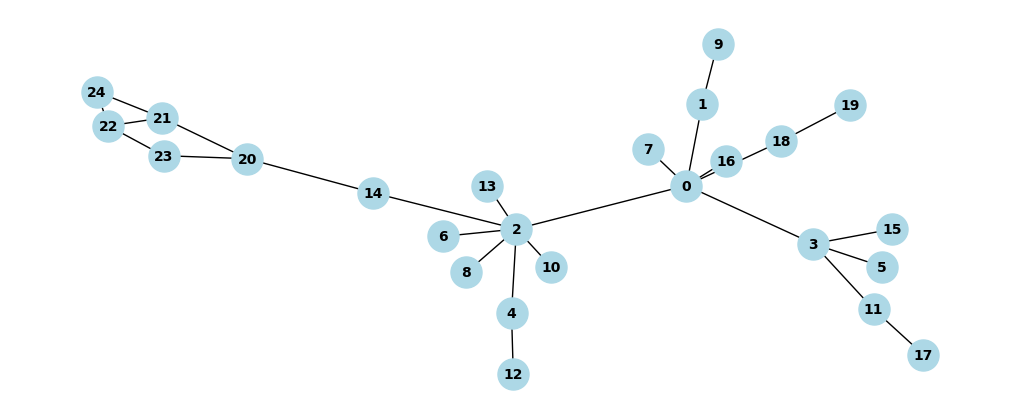

In [174]:
# Add edges to the graph
G = nx.Graph()

for i in range(edge_index.shape[1]):
    G.add_edge(edge_index[0, i].item(), edge_index[1, i].item())

# Set up the plot
plt.figure(figsize=(10, 4))

# Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=500, font_size=10, font_weight='bold')

_ = plt.axis('off')

### __Feeding through GIN__

In [161]:
out = model(features[810], edge_index) #edge_index is dataset[idx].edge_index
pred = out.argmax(dim=1).item()

label = "House" if pred == 1 else "Cycle"
print(f"Predicted Motif: {label}")

Predicted Motif: House


#### __Visualizing the Explanation Subgraph__

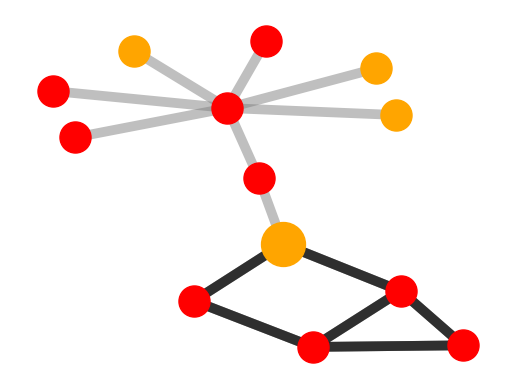

In [162]:
from ExplanationEvaluation.utils.plotting import plot
plot(edge_index, expl, labels, 20, 52, 10, 'ba2', show=True)
#Attachment point is highlighted

In [163]:
label = "House" if labels[idx] == 1 else "Cycle"
print(f"Label: {label}")

Label: House


In [164]:
print(f"Edge Weights:\n{expl}")

Edge Weights:
tensor([9.4209e-03, 4.4736e-04, 5.0818e-03, 9.4125e-03, 9.4125e-03, 9.4209e-03,
        1.1695e-02, 1.6603e-01, 4.0086e-04, 3.5611e-03, 3.4534e-03, 3.4534e-03,
        3.4534e-03, 3.4534e-03, 4.3874e-03, 6.3040e-03, 9.6132e-02, 9.6132e-02,
        9.6132e-02, 4.9308e-03, 1.2444e-01, 9.5842e-02, 4.7737e-03, 1.1685e-02,
        4.7737e-03, 1.6501e-01, 4.7737e-03, 9.5842e-02, 2.0884e-01, 1.2381e-01,
        4.7737e-03, 6.0852e-03, 3.3097e-08, 9.5842e-02, 1.1685e-02, 2.0884e-01,
        1.1695e-02, 1.6603e-01, 1.6501e-01, 4.8736e-21, 1.6416e-14, 9.0691e-09,
        1.6219e-22, 1.6219e-22, 1.0484e-21, 4.8736e-21, 1.6416e-14, 1.6416e-14,
        2.1088e-14, 2.1088e-14, 4.0497e-20, 2.1088e-14],
       grad_fn=<IndexPutBackward0>)
